In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

SEED = 0

In [2]:
data = pd.read_csv(r'..\data_for_modeling\data\heart_cleveland_upload.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
with open(r'..\data_for_modeling\data\data_description.txt') as f:
    print(f.read())

Data description:
   age: age in years
   sex: sex (1 = male; 0 = female)
   cp: chest pain type
      -- Value 0: typical angina
      -- Value 1: atypical angina
      -- Value 2: non-anginal pain
      -- Value 3: asymptomatic
   trestbps: resting blood pressure (in mm Hg on admission to the hospital)
   chol: serum cholestoral in mg/dl
   fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
   restecg: resting electrocardiographic results
      -- Value 0: normal
      -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
      -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
   thalach: maximum heart rate achieved
   exang: exercise induced angina (1 = yes; 0 = no)
   oldpeak = ST depression induced by exercise relative to rest
   slope: the slope of the peak exercise ST segment
      -- Value 0: upsloping
      -- Value 1: flat
      -- Value 2: downsloping
   ca: number of major

In [4]:
def data_stats_table(data, data_example=True, nlargest_num=1, stats_describe=True):
    """
    Функция для описания табличных данных (Nans, дубли, частоты значений, статистика)      
    """ 
    data_stats = pd.DataFrame()

    if data_example:  # пример данных
        data_stats['data[0]'] = data.loc[0, :].T

    data_stats['dtypes'] = data.dtypes  # типы переменных
    data_stats.loc['rows_count', 'dtypes'] = len(data.dtypes)

    # расчет количества дублей
    data_stats['dupl'] = int(data.duplicated().sum())

    data_stats['NaNs'] = data.isnull().sum()  # Расчет количества NaNs
    data_stats.loc['rows_count', 'NaNs'] = (
        data.isnull().sum(axis=1) != 0).sum()
    data_stats['NaNs'] = data_stats['NaNs'].astype('int')

    # Расчет частот уникальных значений (частоты нормированы)
    for name in data.columns:
        data_stats.loc[name, 'unique'] = data[name].nunique()
        top_freq = round(data[name].value_counts(
            normalize=True).nlargest(nlargest_num), 2)
        data_stats.loc[name, 'top_freq'] = json.dumps(list(top_freq))
        data_stats.loc[name, 'top_freq_value'] = json.dumps(
            list(top_freq.index))

    if stats_describe:  # описательная статистика
        df_des = round(data.describe().T.drop(columns=['count']), 2)
        data_stats = pd.concat([data_stats, df_des], axis=1, sort=False)

    data_stats.fillna("", inplace=True)
    return data_stats

data_stats_table(data, nlargest_num=3)

,data[0],dtypes,dupl,NaNs,unique,top_freq,top_freq_value,mean,std,min,25%,50%,75%,max
age,69.0,int64,0,0,41.0,"[0.06, 0.06, 0.05]","[58, 57, 54]",54.54,9.05,29.0,48.0,56.0,61.0,77.0
sex,1.0,int64,0,0,2.0,"[0.68, 0.32]","[1, 0]",0.68,0.47,0.0,0.0,1.0,1.0,1.0
cp,0.0,int64,0,0,4.0,"[0.48, 0.28, 0.16]","[3, 2, 1]",2.16,0.96,0.0,2.0,2.0,3.0,3.0
trestbps,160.0,int64,0,0,50.0,"[0.12, 0.12, 0.11]","[120, 130, 140]",131.69,17.76,94.0,120.0,130.0,140.0,200.0
chol,234.0,int64,0,0,152.0,"[0.02, 0.02, 0.02]","[197, 234, 204]",247.35,52.0,126.0,211.0,243.0,276.0,564.0
fbs,1.0,int64,0,0,2.0,"[0.86, 0.14]","[0, 1]",0.14,0.35,0.0,0.0,0.0,0.0,1.0
restecg,2.0,int64,0,0,3.0,"[0.49, 0.49, 0.01]","[0, 2, 1]",1.0,0.99,0.0,0.0,1.0,2.0,2.0
thalach,131.0,int64,0,0,91.0,"[0.04, 0.03, 0.03]","[162, 160, 163]",149.6,22.94,71.0,133.0,153.0,166.0,202.0
exang,0.0,int64,0,0,2.0,"[0.67, 0.33]","[0, 1]",0.33,0.47,0.0,0.0,0.0,1.0,1.0
oldpeak,0.1,float64,0,0,40.0,"[0.32, 0.06, 0.05]","[0.0, 1.2, 0.6]",1.06,1.17,0.0,0.0,0.8,1.6,6.2


#### Выводы
- Дубликатов нет
- Пропущенных значений нет
- Целевой признак - condition. Дисбаланса классов нет (54% - 1 и 46% - 0)
- экстремальные значения (выбросы) не наблюдаются

In [5]:
def plot_scores(results, x_lim=(0, 10), y_lim=(0, 1), parameter=""):
    """
    Функция для построения кривых обучения    
    """
    if parameter=="":
        return
    
    plt.figure(figsize=(15, 5))
    plt.xlabel("Parameter - " + parameter)
    plt.ylabel("AUC")

    ax = plt.gca()
    ax.set_xlim(x_lim[0], x_lim[1])
    ax.set_ylim(y_lim[0], y_lim[1])
    
    X_axis = np.array(results["param_" + parameter].data, dtype=float)
    
    std_lst = {}
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, 'score')]
        sample_score_std = results["std_%s_%s" % (sample, 'score')]
        std_lst[sample] = round(sample_score_std.mean(), 4)
        ax.fill_between(X_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color='g')
        ax.plot(X_axis,
                sample_score_mean,
                style,
                color='g',
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % ('roc_auc', sample))

    best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
    best_score = results["mean_test_score"][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index]] * 2,
            [0, best_score],
            linestyle="-.",
            color='g',
            marker="x",
            markeredgewidth=3,
            ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score, (X_axis[best_index], best_score + 0.005))
    plt.legend()
    plt.grid(False)

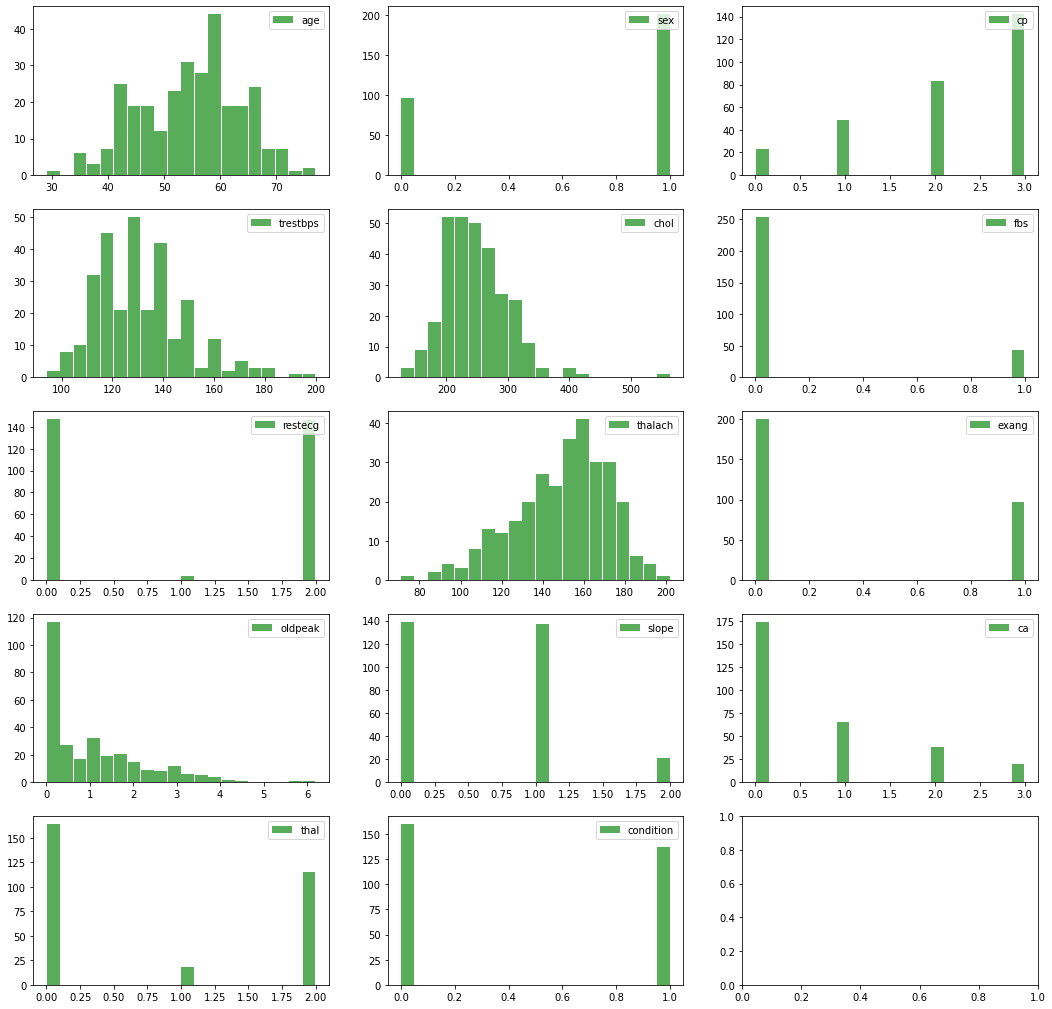

In [6]:
def plot_train_test_hist(data_, col_names, col_number=2, figsize_=(18, 8), bins_=10):
    fig, axes_ = plt.subplots(-(-len(col_names)//col_number),
                              col_number, figsize=figsize_)

    for counter_ in range(len(col_names)):
        pic_row_ = counter_//col_number
        pic_col_ = counter_ % col_number
        axes_[pic_row_, pic_col_].hist(data_[col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label=col_names[counter_], color='green', bins=bins_)
        axes_[pic_row_, pic_col_].legend(loc=1)

plot_train_test_hist(data, list(data.columns), col_number=3, figsize_=(18, 18), bins_=20)

In [7]:
# непрерывные признаки
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# дискретные признаки
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

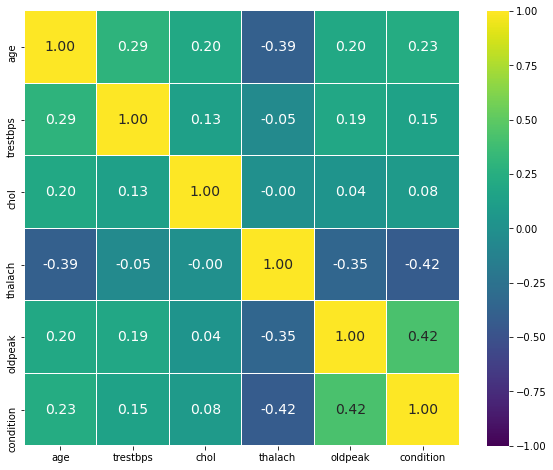

In [8]:
corr = data[num_cols + ['condition']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 14}, square=True, fmt='.2f');

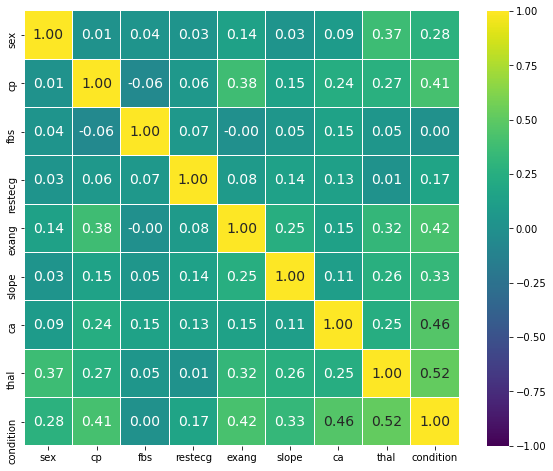

In [9]:
corr_cut = 0
corr = data[cat_cols + ['condition']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 14}, square=True, fmt='.2f');

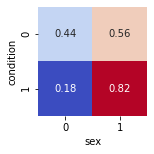

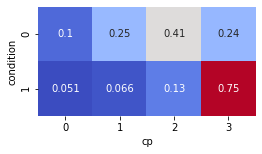

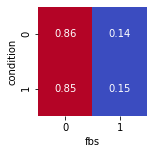

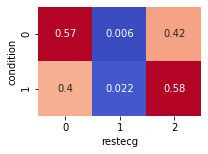

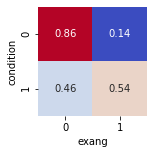

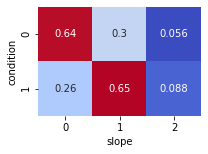

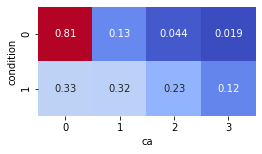

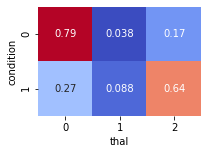

In [10]:
def plot_cross_tab(data_, col_names, target_name, figsize_=(18, 8)):
    for col_name in col_names:
        df = data_.copy()
        df_cross_tab = pd.crosstab(df[target_name], df[col_name], normalize='index')
        df_cross_tab = np.round(df_cross_tab, 3)
        plt.figure(figsize=figsize_)
        sns.heatmap(df_cross_tab, annot=True, square=True,
                    cmap='coolwarm', cbar=False)
        plt.show


plot_cross_tab(data, cat_cols, target_name='condition', figsize_=(16, 2))

#### Выводы
- Признаки с наибольшим влиянием **thalach, oldpeak, sex, cp, exang, slope, ca, thal**

### Обучение различных моделей (прототип)

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(data[cat_cols])
X_cat = ohe.transform(data[cat_cols]).toarray()

scaler = StandardScaler()
X_num = scaler.fit_transform(data[num_cols].values)

X = np.hstack((X_num, X_cat))
y = data['condition'].values

In [12]:
model_list = [LogisticRegression(random_state=SEED), 
              RandomForestClassifier(random_state=SEED), 
              GradientBoostingClassifier(random_state=SEED), 
              KNeighborsClassifier()]

for model in model_list:
    scores = np.round(cross_val_score(model, X, y, scoring='roc_auc', cv=5), 3)
    print(f'{str(model):<45} - CV_mean: {scores.mean():.3f},  CV: {scores}')

LogisticRegression(random_state=0)            - CV_mean: 0.888,  CV: [0.762 0.905 0.898 0.969 0.906]
RandomForestClassifier(random_state=0)        - CV_mean: 0.848,  CV: [0.701 0.925 0.868 0.973 0.774]
GradientBoostingClassifier(random_state=0)    - CV_mean: 0.791,  CV: [0.748 0.771 0.887 0.882 0.667]
KNeighborsClassifier()                        - CV_mean: 0.856,  CV: [0.753 0.911 0.87  0.964 0.784]


#### Выводы
- Без подбора гиперпараметров лучшие результаты среди рассмотренных классификаторов демострируют
    - LogisticRegression (1 место)
    - KNeighborsClassifier (2 место)
- Качество моделей  (среднее на тесте при кроссвалидации) высокое:
    - LogisticRegression: roc_auc = 0.888
    - KNeighborsClassifier: roc_auc = 0.856
- В качестве финальных моделей выбраны классификаторы: LogisticRegression, KNeighborsClassifier

### Подбор значения гиперпараметра KNeighborsClassifier

In [13]:
estimator = KNeighborsClassifier()

# Словарь с параметрами модели, которые будут подбираться в процессе кросс-валидации
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]}
cv = 6
optimizer = GridSearchCV(estimator, 
                           param_grid, 
                           scoring = 'roc_auc', 
                           cv = cv,
                           return_train_score = True
                           )

# Обучите optimizer на тренировочных данных
optimizer.fit(X, y);

# Выводим модель с лучшим качеством поиска оптимальных значений
print(round(optimizer.best_score_, 3))
print(optimizer.best_params_)

0.872
{'n_neighbors': 23}


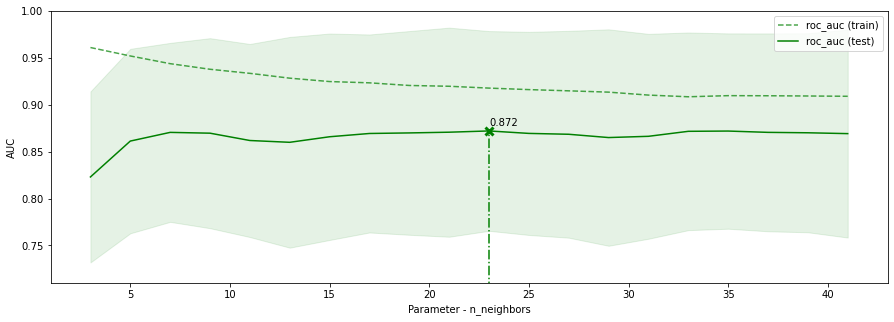

In [14]:
plot_scores(optimizer.cv_results_, x_lim=(1, 43), y_lim=(0.71, 1), parameter = 'n_neighbors');

### Подбор значения гиперпараметра LogisticRegression

In [15]:
estimator = LogisticRegression(penalty = 'l2',
                               solver='liblinear',
                               random_state=SEED)

# Словарь с параметрами модели, которые будут подбираться в процессе кросс-валидации
param_grid = {'C': [0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4]}
cv = 6
optimizer_2 = GridSearchCV(estimator, 
                           param_grid, 
                           scoring = 'roc_auc', 
                           cv = cv,
                           return_train_score = True)

# Обучите optimizer на тренировочных данных
optimizer_2.fit(X, y);

# Выводим модель с лучшим качеством поиска оптимальных значений
print(round(optimizer_2.best_score_, 3))
print(optimizer_2.best_params_)

0.894
{'C': 0.2}


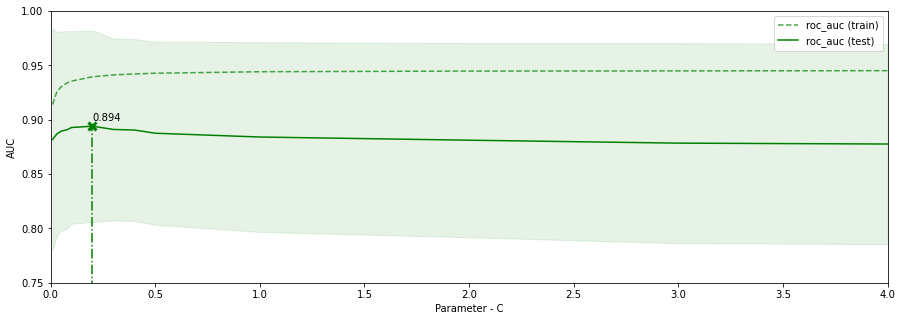

In [16]:
plot_scores(optimizer_2.cv_results_, x_lim=(0, 4), y_lim=(0.75, 1), parameter = 'C');

#### Выводы
- KNeighborsClassifier:
    - Подобран гиперпараметр n_neighbors = 23 для модели KNeighborsClassifier
    - Качество модели (среднее на тесте при кроссвалидации) KNeighborsClassifier выросло: roc_auc = 0.872
- LogisticRegression:
    - Подобран гиперпараметр C = 0.2 для модели LogisticRegression
    - Качество модели (среднее на тесте при кроссвалидации) LogisticRegression выросло: roc_auc = 0.894 